# Previsão de Passageiros Aéreos com Holt-Winters ✈️

Este notebook demonstra, de ponta a ponta, a aplicação do método **Holt-Winters** usando `statsmodels`
em uma série temporal, utilizando o dataset **AirPassengers**, com observações mensais de 1949 a 1960.

**Objetivo:** treinar um modelo de previsão de demanda de passageiros, validando o desempenho por meio de _grid search_,
refazendo o ajuste final com os melhores parâmetros e gerando previsões para os **12 meses seguintes**.

**Etapas:**
1. Importação e exploração do dataset
2. EDA rápida
3. Funções de suporte ao modelo
4. Split temporal e _grid search_ de parâmetros
5. Refit e previsão final (12 meses)
6. Gráfico final entre histórico e previsão
7. Exportação dos artefatos (CSV, JSON, PNG)

## 1) Importação e exploração do dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pathlib import Path
import json

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True

# Carregamento do dataset AirPassengers
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url)
df.columns = ["data", "passageiros"]
df["data"] = pd.to_datetime(df["data"])
df = df.set_index("data").asfreq("MS")

df.head()


,passageiros
data,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


## 2) EDA rápida e visualização inicial

Shape: (144, 1)
Período: 1949-01-01 00:00:00 → 1960-12-01 00:00:00
Frequência inferida: MS

Resumo estatístico:
       passageiros
count   144.000000
mean    280.298611
std     119.966317
min     104.000000
25%     180.000000
50%     265.500000
75%     360.500000
max     622.000000


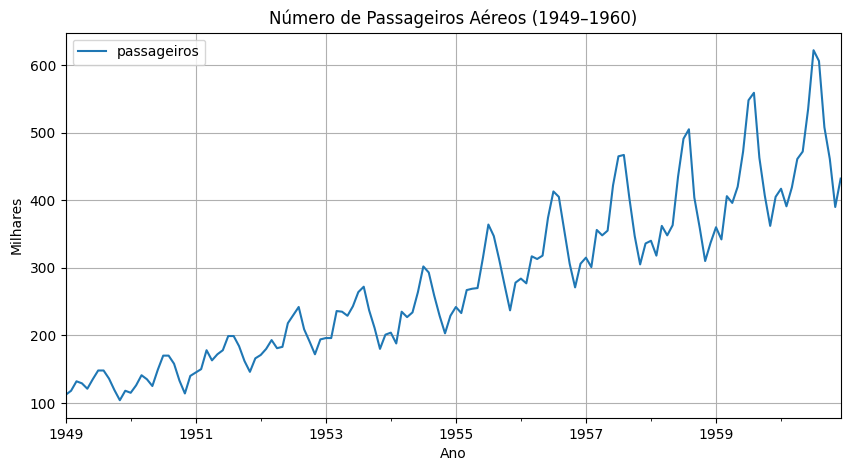

In [3]:
print("Shape:", df.shape)
print("Período:", df.index.min(), "→", df.index.max())
print("Frequência inferida:", pd.infer_freq(df.index))
print("\nResumo estatístico:")
print(df.describe())

df.plot(title="Número de Passageiros Aéreos (1949–1960)", ylabel="Milhares", xlabel="Ano")
plt.show()

Tendência crescente e sazonalidade anual, com picos no verão e vales no inverno.

## 3) Funções de suporte ao modelo

In [12]:
# Definindo funções reutilizáveis para organizar o fluxo da modelagem

def time_split(series: pd.Series, val_periods: int = 12):
    if val_periods <= 0 or val_periods >= len(series):
        raise ValueError("val_periods deve estar entre 1 e len(series)-1.")
    y_train = series.iloc[:-val_periods]
    y_val = series.iloc[-val_periods:]
    return y_train, y_val

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true_safe = np.where(y_true == 0, 1e-8, y_true)
    return np.mean(np.abs((y_true - y_pred) / y_true_safe)) * 100

def rmse(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sqrt(np.mean((y_true - y_pred) ** 2))


# Busca de hiperparâmetros
def grid_search_holt_winters(y_train, y_val,
                             seasonal_periods_grid=(12,),
                             trend_opts=("add", "mul"),
                             seasonal_opts=("add", "mul")):
    results = []
    for sp in seasonal_periods_grid:
        for trend in trend_opts:
            for seasonal in seasonal_opts:
                try:
                    model = ExponentialSmoothing(
                        y_train, trend=trend, seasonal=seasonal,
                        seasonal_periods=sp, initialization_method="estimated"
                    ).fit(optimized=True)
                    y_hat = model.forecast(len(y_val))
                    res = {
                        "seasonal_periods": sp,
                        "trend": trend,
                        "seasonal": seasonal,
                        "MAPE": mape(y_val, y_hat),
                        "RMSE": rmse(y_val, y_hat)
                    }
                    results.append(res)
                except Exception as e:
                    results.append({
                        "seasonal_periods": sp, "trend": trend, "seasonal": seasonal,
                        "MAPE": np.inf, "RMSE": np.inf, "error": str(e)
                    })
    return pd.DataFrame(results).sort_values(by=["MAPE", "RMSE"]).reset_index(drop=True)

## 4) Split temporal e _grid search_

In [13]:
series = df["passageiros"]
y_train, y_val = time_split(series, val_periods=12)

search = grid_search_holt_winters(
    y_train, y_val,
    seasonal_periods_grid=(12,),
    trend_opts=("add", "mul"),
    seasonal_opts=("add", "mul")
)

print("Top 5 combinações:")
display(search.head())

Top 5 combinações:


,seasonal_periods,trend,seasonal,MAPE,RMSE
0,12,add,mul,2.207421,15.810380
1,12,add,add,2.803136,16.981068
2,12,mul,add,3.001162,18.305668
3,12,mul,mul,4.326515,25.809151


## 5) Refit final e previsão de 12 meses

In [14]:
best = search.iloc[0].to_dict()
trend, seasonal, sp = best["trend"], best["seasonal"], int(best["seasonal_periods"])

final_model = ExponentialSmoothing(
    series, trend=trend, seasonal=seasonal, seasonal_periods=sp,
    initialization_method="estimated"
).fit(optimized=True)

forecast = final_model.forecast(12)
print("Melhor configuração:", best)

Melhor configuração: {'seasonal_periods': 12, 'trend': 'add', 'seasonal': 'mul', 'MAPE': 2.2074214313335156, 'RMSE': 15.81038040261183}


## 6) Gráfico final — histórico, fitted e previsão (sem gap)

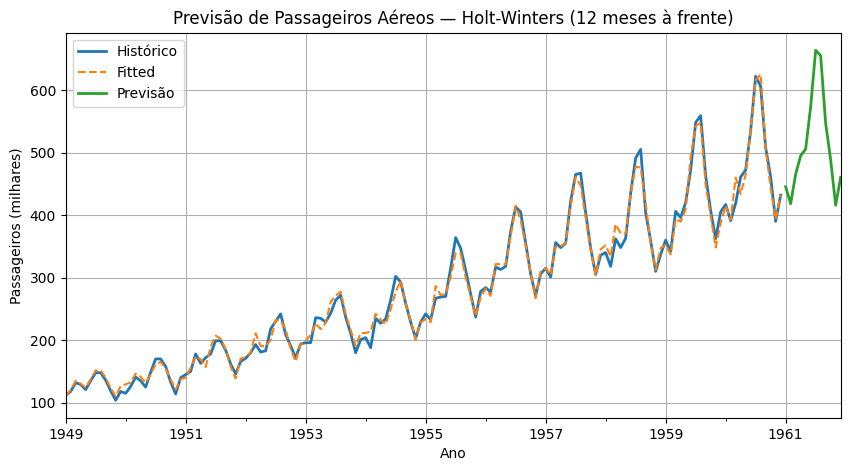

In [21]:
ax = series.plot(label="Histórico", linewidth=2)
pd.Series(final_model.fittedvalues, index=series.index).plot(ax=ax, linestyle="--", label="Fitted")
forecast.plot(ax=ax, label="Previsão", linewidth=2)

ax.set_title("Previsão de Passageiros Aéreos — Holt-Winters (12 meses à frente)")
ax.set_xlabel("Ano")
ax.set_ylabel("Passageiros (milhares)")
ax.legend()
plt.show()

## 7) Exportação dos artefatos (CSV, JSON, PNG)

In [18]:
out_dir = Path("/mnt/data")
out_dir.mkdir(parents=True, exist_ok=True)

# CSV e JSON
pd.DataFrame({"data": forecast.index, "previsao": forecast.values}).to_csv(out_dir / "previsao_airpassengers.csv", index=False)
with open(out_dir / "melhor_config_airpassengers.json", "w") as f:
    json.dump(best, f, ensure_ascii=False, indent=2)

# PNG
fig_path = out_dir / "holt_winters_airpassengers.png"
ax = series.plot(label="Histórico", linewidth=2)
pd.Series(final_model.fittedvalues, index=series.index).plot(ax=ax, linestyle="--", label="Fitted")
forecast.plot(ax=ax, label="Previsão", linewidth=2)
ax.set_title("Previsão de Passageiros Aéreos — Holt-Winters (12 meses à frente)")
ax.set_xlabel("Ano")
ax.set_ylabel("Passageiros (milhares)")
ax.legend()
plt.savefig(fig_path, bbox_inches="tight")
plt.close()

print("Arquivos salvos em:", out_dir)
print(" - previsao_airpassengers.csv")
print(" - melhor_config_airpassengers.json")
print(" - holt_winters_airpassengers.png")

Arquivos salvos em: /mnt/data
 - previsao_airpassengers.csv
 - melhor_config_airpassengers.json
 - holt_winters_airpassengers.png


In [22]:
import os

# Procurar recursivamente por arquivos com esses nomes
for root, dirs, files in os.walk("/"):
    for file in files:
        if "airpassengers" in file.lower():
            print(os.path.join(root, file))

/mnt/data/holt_winters_airpassengers.png
/mnt/data/previsao_airpassengers.csv
/mnt/data/melhor_config_airpassengers.json


In [23]:
from google.colab import files
files.download("/mnt/data/holt_winters_airpassengers.png")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
from google.colab import files
files.download("/mnt/data/previsao_airpassengers.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [25]:
from google.colab import files
files.download("/mnt/data/melhor_config_airpassengers.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>